In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

In [2]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [3]:
# get initial phase
nmem = 1
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')

if nmem == 1:
    a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
    b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
elif nmem == 30:
    a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
    b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

iniRMM = xr.concat((a,b), dim='time')
del a 
del b 
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
Phase = np.zeros(len(RMM1))

for i in np.arange(len(RMM1)):
    Phase[i] = get_phase(RMM1[i],RMM2[i])

Phase

array([4., 4., 5., ..., 7., 7., 8.])

In [4]:
# analyze error source
nmem = 1

# dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_ep50_1mem/'
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
varnum = 19

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead

RMSE = []
err  = []
ds = []
pha_err = []

for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

    # combine 2015-2019 prediction for the lead
    dsp = []
    dst = []
    dspstd = []

    for yn in np.arange(2015,2020):
        # fnp=dirn + 'predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        # fnt=dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        # fnpstd=dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        fnp=dirn + 'predicted_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnt=dirn + 'truth_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
        dsp.append(df)
        del df 
        df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
        dst.append(df)
        del df 
        df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
        dspstd.append(df)
        del df 

    dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
    dst0 = pd.concat(dst, axis=0, ignore_index=True)
    dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

    ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

    ds.append(ds0)
    del ds0
        
    iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    
    if nmem == 1:
        a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

    iniRMM = xr.concat((a,b), dim='time')
    del a 
    del b 
    RMM1 = iniRMM['RMM'][:,0]
    RMM2 = iniRMM['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
    ds[ilead]['IniAmp'] = IniAmp.values 
    ds[ilead]['time'] =  iniRMM.time.values
    ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].time).month
    ds[ilead]['Phase'] = Phase

    std1 = ds[ilead]['std1']
    std2 = ds[ilead]['std2']
    std = np.sqrt(std1*std1+std2*std2)
    ds[ilead]['std'] = std.values

    # finish combination
    # evaluation starts 
    ds0 = ds[ilead]
    ds0 = ds0.loc[ds0['IniAmp']>=1]
    ds[ilead] = ds0

    r1p = np.asarray(ds0['RMMp1'])
    r2p = np.asarray(ds0['RMMp2'])
    r1t = np.asarray(ds0['RMMt1'])
    r2t = np.asarray(ds0['RMMt2'])
    std = np.asarray(ds0['std'])

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    ds[ilead]['RMSE'] = np.sqrt(d)
    RMSE.append(np.sqrt(d))  # RMSE at each time step
    err.append(std)

    a = r1t * r2p - r2t * r1p 
    b = r1t * r1p + r2t * r2p
    c = a / b 
    d = np.arctan(c) * 180. / np.pi
    ds[ilead]['pha_err'] = d
    pha_err.append(d)

    del ds0 


In [5]:
np.shape(RMSE)

(8, 1033)

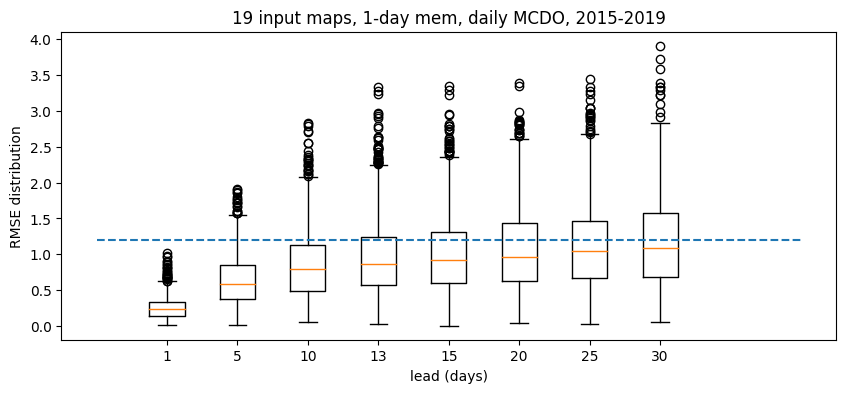

In [6]:
# ds[ilead]['time']
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(RMSE)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019')
ax.plot(np.arange(11),1.2*np.ones(11),'--')

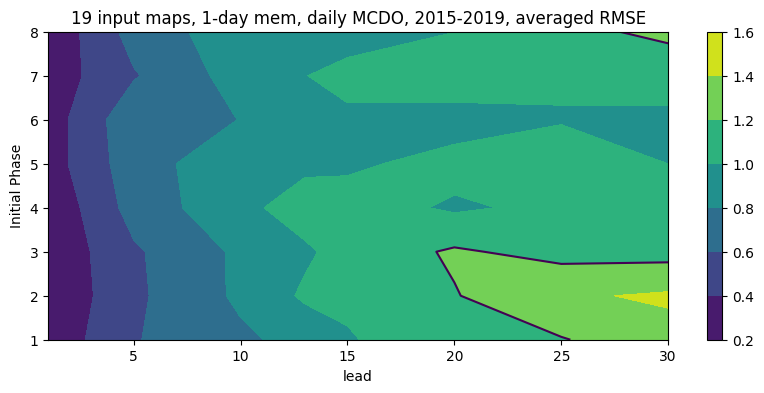

In [7]:
# lead and phase plot
lead = [1, 5, 10, 13, 15, 20, 25, 30]
ds1 = ds
RMSE = np.zeros((len(lead),8))
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(len(lead)), lead):
    RMSE[ilead,:] = ds1[ilead].groupby(['Phase']).mean()['RMSE']

h = ax.contourf(lead, np.arange(1,9), np.transpose(RMSE))
# ax.legend(ncol=len(lead))
ax.set_xlabel('lead')
ax.set_ylabel('Initial Phase')
ax.set_title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019, averaged RMSE')
plt.colorbar(h)
ax.contour(lead, np.arange(1,9), np.transpose(RMSE),[1.2])

Text(0.5, 1.0, '19 input maps, 1-day mem, daily MCDO, 2015-2019, lead = 13')

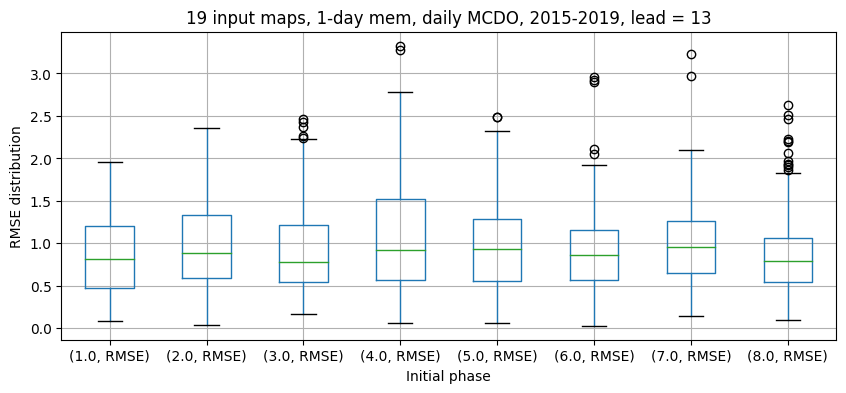

In [8]:
# for lead = 15 how the error depends on initial phase?
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(ds1[ilead].count()['std'], 'o', label=leadmjo)
ds[3].groupby(['Phase']).boxplot(subplots=False, column='RMSE')
# ax.set_xticklabels(lead)
plt.xlabel('Initial phase')
plt.ylabel('RMSE distribution')
plt.title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019, lead = 13')
# ax.plot(np.arange(11),1.2*np.ones(11),'--')

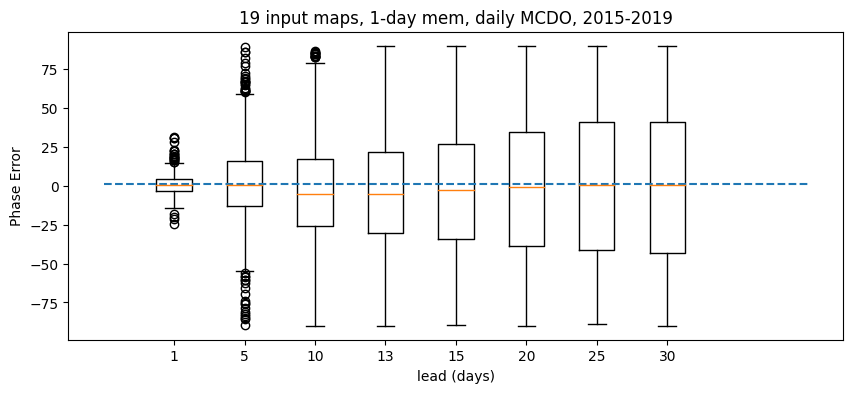

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(pha_err)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('Phase Error')
plt.title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019')
ax.plot(np.arange(11),1.2*np.ones(11),'--')

Text(0.5, 1.0, '19 input maps, 1-day mem, daily MCDO, 2015-2019')

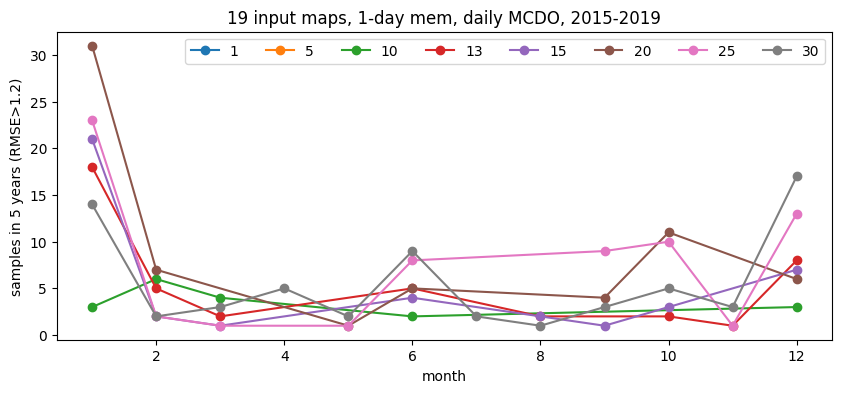

In [13]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]
ds1 = ds
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=1.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o-', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylabel('samples in 5 years (RMSE>1.2)')
ax.set_title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input maps, 1-day mem, daily MCDO, 2015-2019')

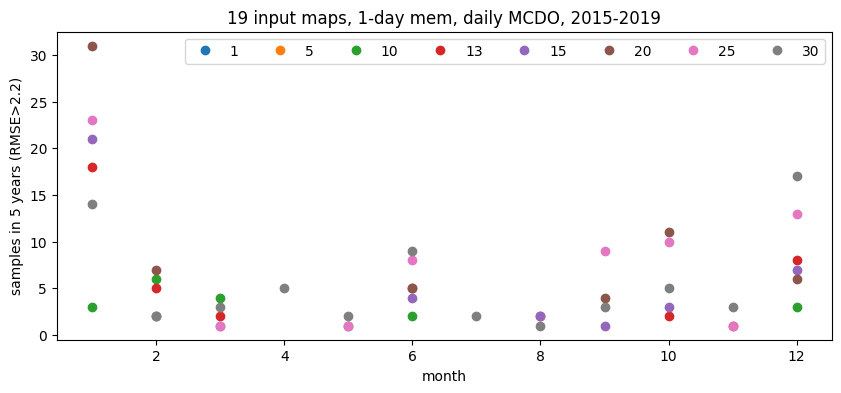

In [14]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]
ds1 = ds
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=2.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylabel('samples in 5 years (RMSE>2.2)')
ax.set_title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input maps, 1-day mem, daily MCDO, 2015-2019')

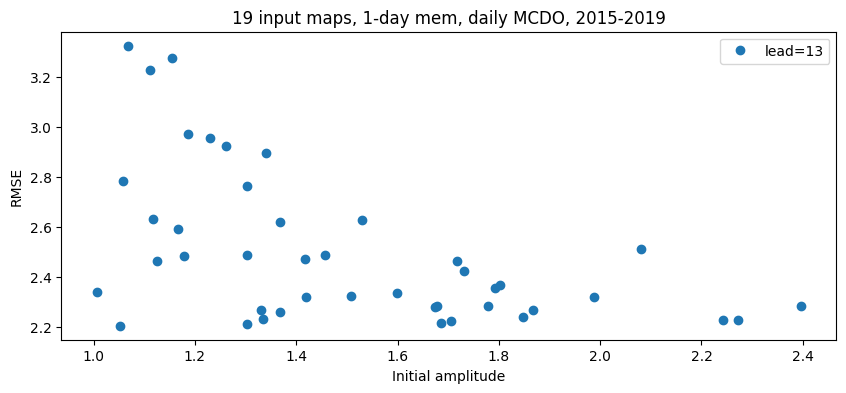

In [15]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]
ilead = 3
ds1 = ds
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ds1[ilead]['IniAmp'].values, ds1[ilead]['RMSE'].values, 'o', label='lead='+str(lead[ilead]))

ax.legend(ncol=len(lead))
ax.set_xlabel('Initial amplitude')
ax.set_ylabel('RMSE')
ax.set_title(str(varnum)+' input maps, 1-day mem, daily MCDO, 2015-2019')

<AxesSubplot:xlabel='month'>

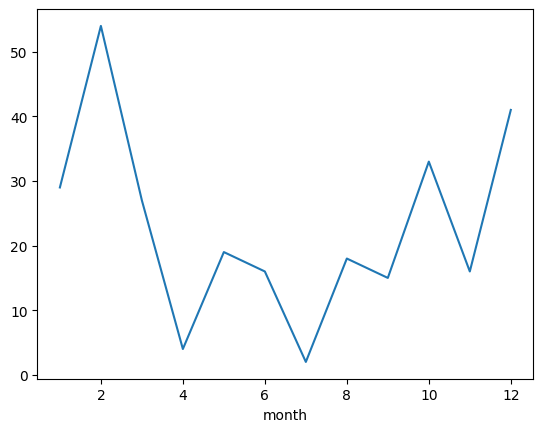

In [23]:
dstmp.groupby(['month']).count()['std'].plot()

In [75]:
# for each lead, which month has the largest error?
RMSE = []
lead = [1, 3, 5, 10, 13, 15, 20, 25, 30]
for ilead, leadmjo in zip(np.arange(len(lead)), lead):
    RMSE_lead = []
    ds0 = ds[ilead]
    for imon in np.arange(1,13):
        dstmp = ds0.loc[ds0['month']==imon]
        RMSE_lead_month = []  # RMSE for a given lead and month

        r1p = np.asarray(dstmp['RMMp1'])
        r2p = np.asarray(dstmp['RMMp2'])
        r1t = np.asarray(dstmp['RMMt1'])
        r2t = np.asarray(dstmp['RMMt2'])
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)  # Error at each time step in a given lead and month
        RMSE_lead_month.append(np.sqrt(d))  # RMSE at each time step
        RMSE_lead.append(RMSE_lead_month)

    RMSE.append(RMSE_lead)

/tmp/ipykernel_205058/1390480320.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.boxplot(np.asarray(RMSE_lead))


ValueError: operands could not be broadcast together with shapes (120,) (116,) 

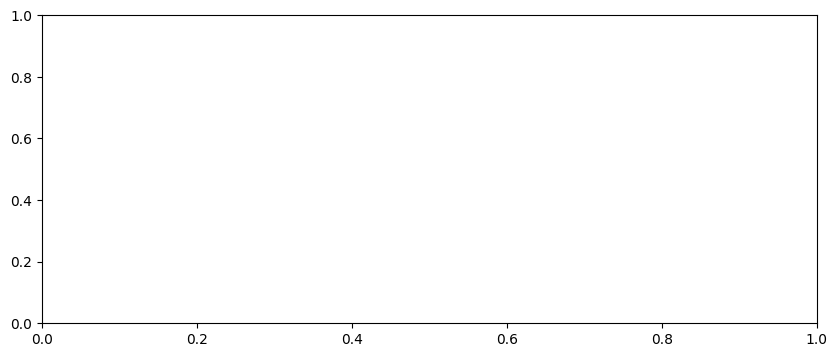

In [78]:
fig, ax = plt.subplots(figsize=(10,4))
plt.boxplot(np.asarray(RMSE_lead))
# ax.set_xticklabels(np.arange(1,13))
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.title('7 input maps, 1-day mem, daily MCDO, 2015-2019, January')
# ax.plot(np.arange(11),1.2*np.ones(11),'--')

In [39]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

# 1 input map
# combine the prediction in 2015-2019
nmem = 1  # use 30 time steps in each input map
varn = ['u200','u500','u850','olr','tcwv','prep','sst','T200','T500','T850','v200','v500','v850','q200','q500','q850','Z200','Z500','Z850']

BCC =[]
RMSE =[]
err = []
avRMSE = []
averr = []

for ivarn, var in zip(np.arange(len(varn)), varn):
    if nmem == 30:
        dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/1maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_1dmem_'+varn[ivarn]+'/'
    elif nmem == 1:
        dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/1maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_1dmem_'+varn[ivarn]+'/'

    lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
    BCC0  = []
    RMSE0 = []
    err0  = []

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
        ds = []
        # combine 2015-2019 prediction for the lead
        dsp = []
        dst = []
        dspstd = []

        for yn in np.arange(2015,2020):
            fnp=dirn + 'predicted_disav_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnt=dirn + 'truth_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

            df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
            dsp.append(df)
            del df 
            df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
            dst.append(df)
            del df 
            df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
            dspstd.append(df)
            del df 

        dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
        dst0 = pd.concat(dst, axis=0, ignore_index=True)
        dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

        ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

        ds.append(ds0)
        del ds0
            
        iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
        
        if nmem == 1:
            a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
            b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
        elif nmem == 30:
            a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
            b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

        iniRMM = xr.concat((a,b), dim='time')
        del a 
        del b 
        RMM1 = iniRMM['RMM'][:,0]
        RMM2 = iniRMM['RMM'][:,1]
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
        ds[0]['IniAmp'] = IniAmp.values 

        std1 = ds[0]['std1']
        std2 = ds[0]['std2']
        std = np.sqrt(std1*std1+std2*std2)
        ds[0]['std'] = std.values

        # finish combination
        # evaluation starts 
        ds = ds[0]
        ds = ds.loc[ds['IniAmp']>=1]

        r1p = np.asarray(ds['RMMp1'])
        r2p = np.asarray(ds['RMMp2'])
        r1t = np.asarray(ds['RMMt1'])
        r2t = np.asarray(ds['RMMt2'])
        std = np.asarray(ds['std'])

        A = np.sum(r1p * r1t + r2p * r2t)
        B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
        C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
        BCC0.append(A / B / C)

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE0.append(np.sqrt(d))  # RMSE at each time step
        err0.append(std)
        del ds 

    avRMSE.append(np.mean(RMSE0,axis=1))
    averr.append(np.mean(err0,axis=1))
    BCC.append(BCC0)
    RMSE.append(RMSE0)
    err.append(err0)


(0.1, 1.0)

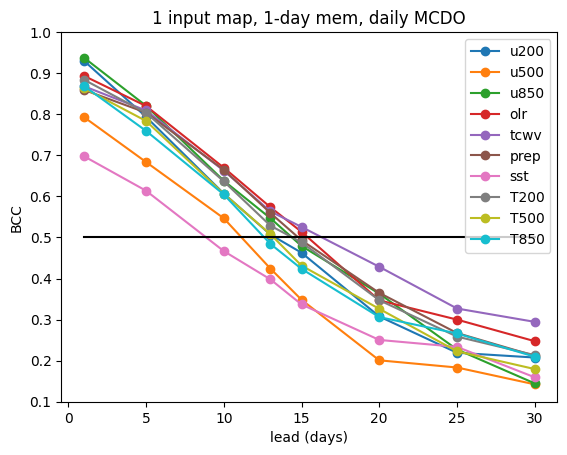

In [40]:
import matplotlib.pyplot as plt 

plt.plot(lead, np.transpose(BCC[0:10]), 'o-', label=varn[0:10])
plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.1, 1.0])

(0.1, 1.0)

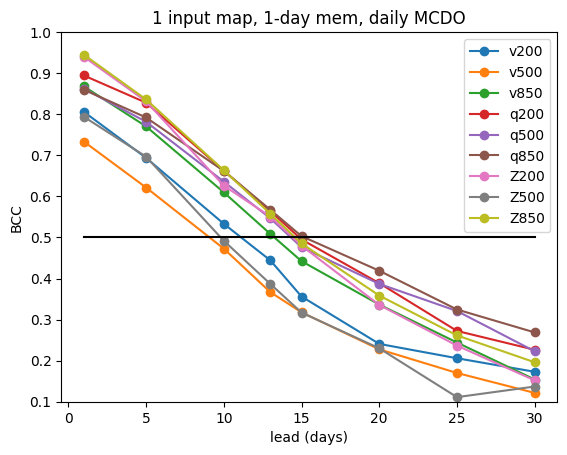

In [41]:
import matplotlib.pyplot as plt 

plt.plot(lead, np.transpose(BCC[10:]), 'o-', label=varn[10:])
plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.1, 1.0])

(0.1, 1.0)

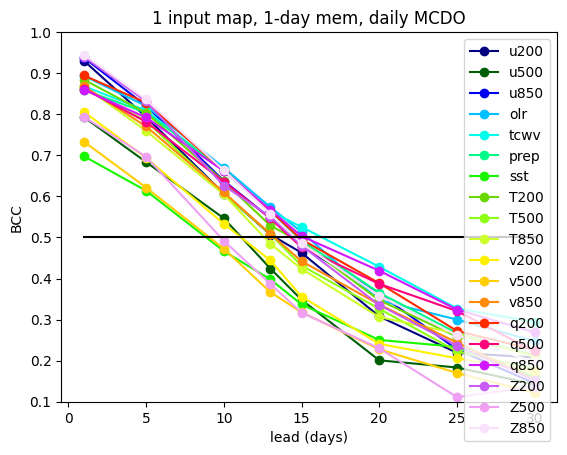

In [44]:
import matplotlib.pyplot as plt 
num_plots = 19
# colormap = plt.cm.Accent
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 0.98, num_plots))))

plt.plot(lead, np.transpose(BCC), 'o-', label=varn)
plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.1, 1.0])

Text(0, 0.5, 'RMSE')

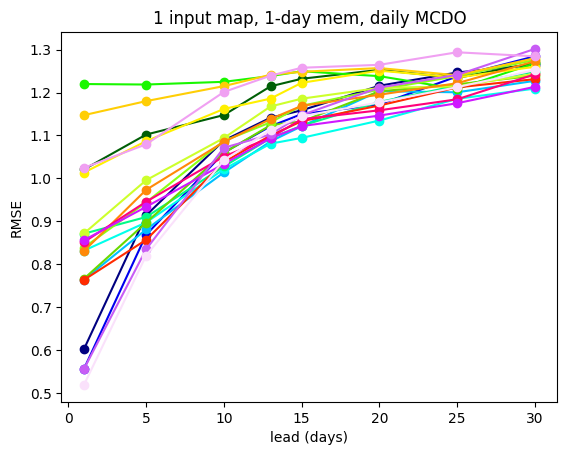

In [46]:
import matplotlib.pyplot as plt 
num_plots = 19
# colormap = plt.cm.Accent
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 0.98, num_plots))))

plt.plot(lead, np.transpose(avRMSE), 'o-', label=varn)
# plt.errorbar(lead, np.transpose(avRMSE), yerr=np.transpose(averr)/2.0, label=varn)
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'RMSE')

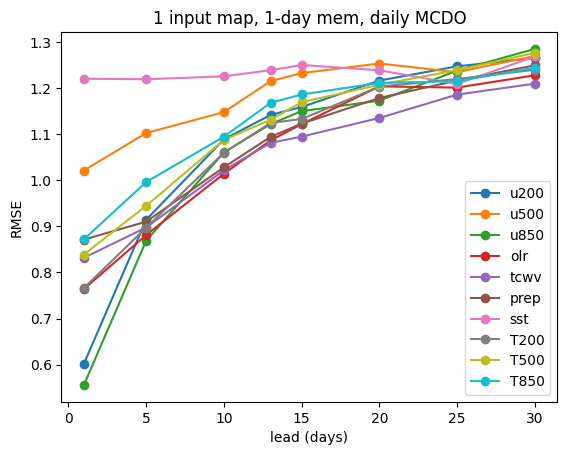

In [51]:
import matplotlib.pyplot as plt 
plt.plot(lead, np.transpose(avRMSE[0:10]), 'o-', label=varn[0:10])
# for i in np.arange(8):
#     plt.errorbar(lead, np.transpose(avRMSE[i]), yerr=np.transpose(averr[i])/2.0, label=varn[i])
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'RMSE')

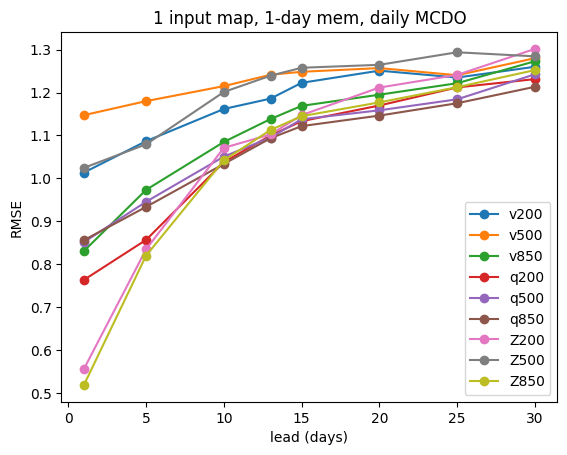

In [52]:
plt.plot(lead, np.transpose(avRMSE[10:]), 'o-', label=varn[10:])
# for i in np.arange(8):
#     plt.errorbar(lead, np.transpose(avRMSE[i]), yerr=np.transpose(averr[i])/2.0, label=varn[i])
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'RMSE uncertainty')

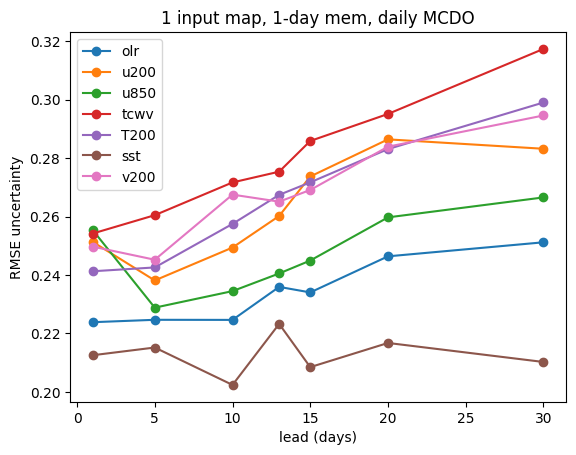

In [20]:
import matplotlib.pyplot as plt 
plt.plot(lead, np.transpose(averr), 'o-', label=varn)
# plt.errorbar(lead, np.transpose(avRMSE), yerr=np.transpose(averr)/2.0, label=varn)
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE uncertainty')

In [12]:
# combine the prediction in 2015-2019
nmem = 1  # use 30 time steps in each input map

dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
varnum = 19

# if nmem == 30:
#     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0203_30mem/'
# elif nmem == 1:
#     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_ep50_1mem/'

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
BCC  = []
RMSE = []
err  = []

for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
    ds = []
    # combine 2015-2019 prediction for the lead
    dsp = []
    dst = []
    dspstd = []

    for yn in np.arange(2015,2020):
        fnp=dirn + 'predicted_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnt=dirn + 'truth_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
        dsp.append(df)
        del df 
        df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
        dst.append(df)
        del df 
        df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
        dspstd.append(df)
        del df 

    dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
    dst0 = pd.concat(dst, axis=0, ignore_index=True)
    dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

    ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

    ds.append(ds0)
    del ds0
        
    iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    
    if nmem == 1:
        a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

    iniRMM = xr.concat((a,b), dim='time')
    del a 
    del b 
    RMM1 = iniRMM['RMM'][:,0]
    RMM2 = iniRMM['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
    ds[0]['IniAmp'] = IniAmp.values 

    std1 = ds[0]['std1']
    std2 = ds[0]['std2']
    std = np.sqrt(std1*std1+std2*std2)
    ds[0]['std'] = std.values

    # finish combination
    # evaluation starts 
    ds = ds[0]
    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    std = np.asarray(ds['std'])

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC.append(A / B / C)

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE.append(np.sqrt(d))  # RMSE at each time step
    err.append(std)
    del ds 

np.shape(RMSE) 


(8, 1033)

Text(0, 0.5, 'BCC')

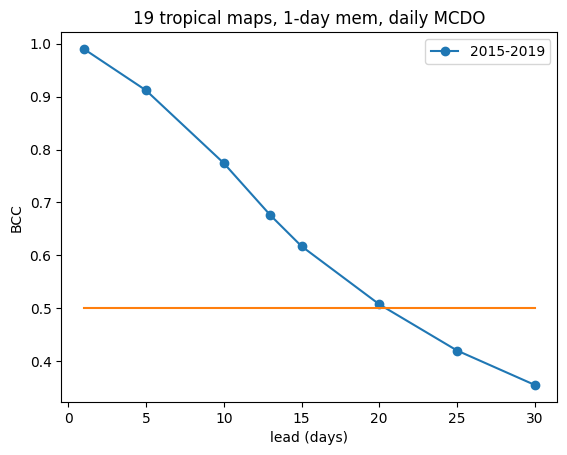

In [13]:
import matplotlib.pyplot as plt 

plt.plot(lead, BCC, 'o-', label='2015-2019')
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()
plt.title(str(varnum)+' tropical maps, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

Text(0, 0.5, 'RMSE')

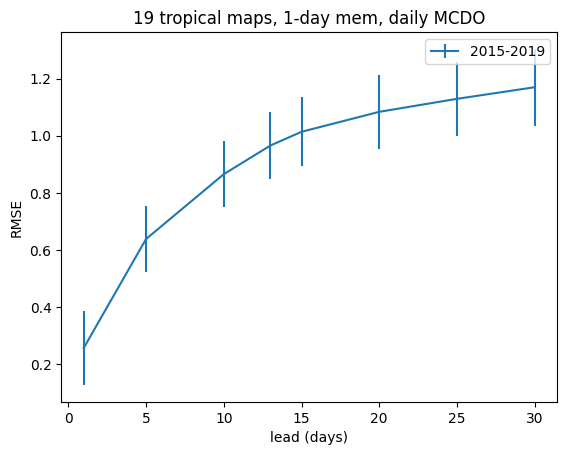

In [14]:
import matplotlib.pyplot as plt 
avRMSE = np.mean(RMSE,axis=1)
averr = np.mean(err,axis=1)
plt.errorbar(lead, avRMSE, yerr=averr/2.0, label='2015-2019')
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title(str(varnum)+' tropical maps, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

In [33]:
RMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_6hr.nc')
RMM = RMM['RMM']

RMM1 = RMM[:,0]
RMM2 = RMM[:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

# RMM1 = RMM1[:].to_dataframe('RMM1')
# RMM2 = RMM2[:].to_dataframe('RMM2')
# IniAmp = IniAmp.to_dataframe('IniAmp')
# ds = pd.concat([RMM1,RMM2,IniAmp],axis=1)
# ds = pd.DataFrame([RMM1,RMM2,IniAmp], columns=['RMM1','RMM2','IniAmp'])
# ds = ds.loc[ds['IniAmp']>=1]
IniAmp

<xarray.DataArray 'RMM' (time: 63428)>
array([1.53457608, 1.74526365, 1.66771841, ..., 1.77491265, 1.55555677,
       1.57537349])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2022-05-31T18:00:00

In [34]:
RMM1.loc[IniAmp>1]

<xarray.DataArray 'RMM' (time: 38439)>
array([ 0.453803,  0.648323,  0.692952, ...,  0.213639,  0.202684, -0.024554])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2022-05-31T18:00:00
    mode     int64 0

AttributeError: 'DataFrame' object has no attribute 'time'

Text(0, 0.5, 'MJO days per year')

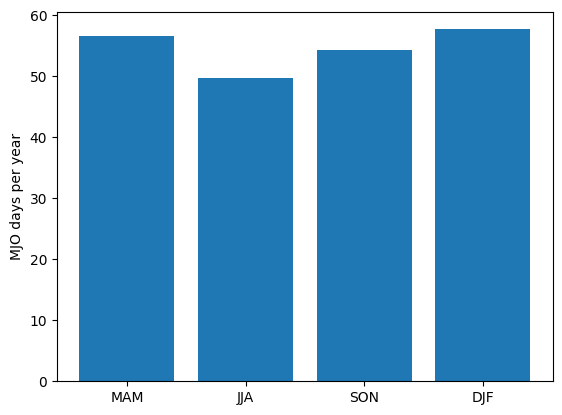

In [55]:
IniAmp1 = IniAmp.loc[IniAmp>1]
clim_RMM = IniAmp1.groupby(IniAmp1.time.dt.season) 
x = np.array(['MAM','JJA','SON','DJF'])
y = np.array([np.shape(clim_RMM['MAM'])[0],np.shape(clim_RMM['JJA'])[0],np.shape(clim_RMM['SON'])[0], np.shape(clim_RMM['DJF'])[0]])
plt.bar(x,y/44/4)
plt.ylabel('MJO days per year')
# plt.xticklable(['MAM','JJA','SON','DJF'])
# plt.boxplot([clim_RMM['DJF'][:,0],clim_RMM['MAM'][:,0],clim_RMM['JJA'][:,0],clim_RMM['SON'][:,0]])


Text(0, 0.5, 'MJO averaged amplitude')

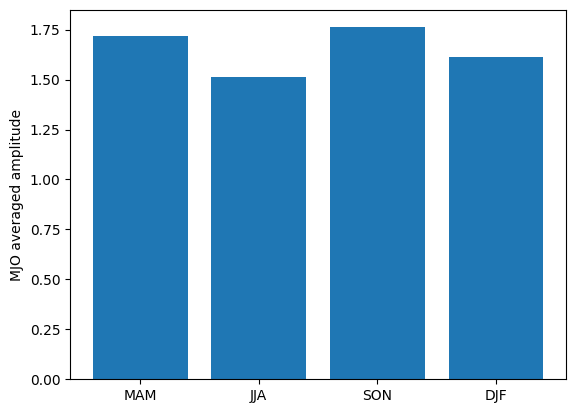

In [56]:
IniAmp1 = IniAmp.loc[IniAmp>1]
clim_RMM = IniAmp1.groupby(IniAmp1.time.dt.season).mean() 
x = np.array(['MAM','JJA','SON','DJF'])
y = np.array(clim_RMM)
plt.bar(x,y)
plt.ylabel('MJO averaged amplitude')
# plt.xticklable(['MAM','JJA','SON','DJF'])
# plt.boxplot([clim_RMM['DJF'][:,0],clim_RMM['MAM'][:,0],clim_RMM['JJA'][:,0],clim_RMM['SON'][:,0]])


In [2]:
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
lead = [1, 5, 10, 15, 20, 25]   # select the prediction lead

RMSE = []
err  = []
mem = lead
memlen = 1 # include two time steps


for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
    ds = []
    # combine 2015-2019 prediction for the lead
    dsp = []
    dst = []
    dspstd = []

    for yn in np.arange(2015,2020):
        fnp=dirn + 'predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem30d' + str(yn) + '.csv'
        fnt=dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem30d' + str(yn) + '.csv'
        fnpstd=dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem30d' + str(yn) + '.csv'

        df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
        dsp.append(df)
        del df 
        df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
        dst.append(df)
        del df 
        df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
        dspstd.append(df)
        del df 

    dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
    dst0 = pd.concat(dst, axis=0, ignore_index=True)
    dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

    ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

    ds.append(ds0)
    del ds0
        
    iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    a = iniRMM.sel(time=slice('2015-01-31','2016-12-30'))
    b = iniRMM.sel(time=slice('2017-01-01','2020-01-30'))
    iniRMM = xr.concat((a,b), dim='time')
    del a 
    del b 
    RMM1 = iniRMM['RMM'][:,0]
    RMM2 = iniRMM['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
    ds[0]['IniAmp'] = IniAmp.values 

    std1 = ds[0]['std1']
    std2 = ds[0]['std2']
    std = np.sqrt(std1*std1+std2*std2) / 2.0
    ds[0]['std'] = std.values

    # finish combination
    # evaluation starts 
    ds = ds[0]
    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    std = np.asarray(ds['std'])

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE.append(np.sqrt(d))
    err.append(std)
    del ds 

RMSE 


FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead5_dailyinput_mem30d2015.csv'

In [64]:
IniAmp1 = IniAmp.loc[IniAmp>1]
# clim_RMM = IniAmp1.groupby(IniAmp1.time.dt.season).mean() 
# x = np.array(['MAM','JJA','SON','DJF'])
# y = np.array(clim_RMM)
# plt.bar(x,y)
# plt.ylabel('MJO averaged amplitude')
# # plt.xticklable(['MAM','JJA','SON','DJF'])
# # plt.boxplot([clim_RMM['DJF'][:,0],clim_RMM['MAM'][:,0],clim_RMM['JJA'][:,0],clim_RMM['SON'][:,0]])
IniAmp1

<xarray.DataArray 'RMM' (time: 1033)>
array([1.4046578, 1.2001272, 1.2132179, ..., 1.2621852, 1.1117226,
       1.1861416], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-29

In [65]:
RMSE[0]

array([0.31091012, 0.28998087, 0.43342751, ..., 0.12698138, 0.20658084,
       0.06926259])

In [68]:
temp = RMSE
df = pd.DataFrame(np.transpose(temp), columns=lead, index=IniAmp1.time)
df 
# clim_RMM = temp.groupby(IniAmp1.time.dt.season)

,1,5,10,15,20,25
2015-01-01,0.310910,0.534347,1.370982,1.094804,0.453332,0.062335
2015-01-02,0.289981,0.939507,0.781048,1.237933,0.381682,0.704752
2015-01-03,0.433428,1.124609,0.223210,0.938566,0.243134,0.859521
2015-01-04,0.364960,1.038124,0.105404,0.675561,0.275653,0.848412
2015-01-05,0.392555,1.092917,0.276632,0.204027,0.187907,1.554407
...,...,...,...,...,...,...
2019-12-25,0.295204,0.554423,1.187401,2.809625,3.112939,2.479533
2019-12-26,0.167065,0.964766,1.683591,3.070619,2.873249,1.984657
2019-12-27,0.126981,0.993985,2.136009,3.156752,3.100560,2.107757
2019-12-28,0.206581,0.691477,2.393471,3.350095,3.210729,2.070074


In [70]:
df['time'] = IniAmp1.time 
df 

,1,5,10,15,20,25,time
2015-01-01,0.310910,0.534347,1.370982,1.094804,0.453332,0.062335,2015-01-01
2015-01-02,0.289981,0.939507,0.781048,1.237933,0.381682,0.704752,2015-01-02
2015-01-03,0.433428,1.124609,0.223210,0.938566,0.243134,0.859521,2015-01-03
2015-01-04,0.364960,1.038124,0.105404,0.675561,0.275653,0.848412,2015-01-04
2015-01-05,0.392555,1.092917,0.276632,0.204027,0.187907,1.554407,2015-01-05
...,...,...,...,...,...,...,...
2019-12-25,0.295204,0.554423,1.187401,2.809625,3.112939,2.479533,2019-12-25
2019-12-26,0.167065,0.964766,1.683591,3.070619,2.873249,1.984657,2019-12-26
2019-12-27,0.126981,0.993985,2.136009,3.156752,3.100560,2.107757,2019-12-27
2019-12-28,0.206581,0.691477,2.393471,3.350095,3.210729,2.070074,2019-12-28


In [72]:
dss = df.to_xarray()

In [73]:
dss

<xarray.Dataset>
Dimensions:  (index: 1033)
Coordinates:
  * index    (index) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-29
Data variables:
    1        (index) float64 0.3109 0.29 0.4334 0.365 ... 0.127 0.2066 0.06926
    5        (index) float64 0.5343 0.9395 1.125 1.038 ... 0.994 0.6915 0.823
    10       (index) float64 1.371 0.781 0.2232 0.1054 ... 2.136 2.393 2.564
    15       (index) float64 1.095 1.238 0.9386 0.6756 ... 3.157 3.35 3.177
    20       (index) float64 0.4533 0.3817 0.2431 0.2757 ... 3.101 3.211 3.229
    25       (index) float64 0.06234 0.7048 0.8595 0.8484 ... 2.108 2.07 1.168
    time     (index) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-29

In [76]:
clim_RMM = dss.groupby(dss.index.dt.season)
clim_RMM

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [78]:
clim_RMM['DJF']

<xarray.Dataset>
Dimensions:  (index: 329)
Coordinates:
  * index    (index) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-29
Data variables:
    1        (index) float64 0.3109 0.29 0.4334 0.365 ... 0.127 0.2066 0.06926
    5        (index) float64 0.5343 0.9395 1.125 1.038 ... 0.994 0.6915 0.823
    10       (index) float64 1.371 0.781 0.2232 0.1054 ... 2.136 2.393 2.564
    15       (index) float64 1.095 1.238 0.9386 0.6756 ... 3.157 3.35 3.177
    20       (index) float64 0.4533 0.3817 0.2431 0.2757 ... 3.101 3.211 3.229
    25       (index) float64 0.06234 0.7048 0.8595 0.8484 ... 2.108 2.07 1.168
    time     (index) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-29

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

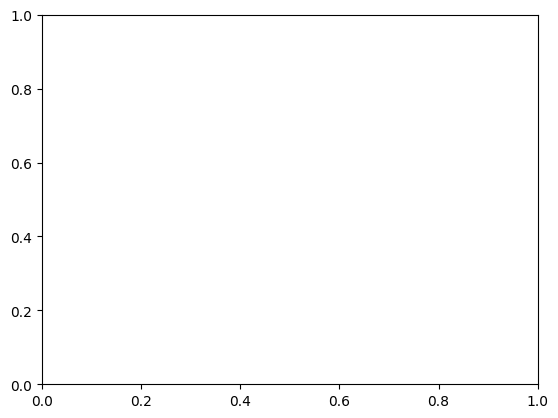

In [77]:
plt.boxplot([clim_RMM['DJF']['15'],clim_RMM['MAM'],clim_RMM['JJA'],clim_RMM['SON']])



In [11]:
clim_RMM = RMM.groupby(RMM['RMM'].time.dt.season)
clim_RMM 

DataArrayGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [75]:
plt.boxplot([clim_RMM['DJF'][:,0],clim_RMM['MAM'][:,0],clim_RMM['JJA'][:,0],clim_RMM['SON'][:,0]])

TypeError: unhashable type: 'slice'

In [12]:
RMM_season = clim_RMM['DJF']
RMM_season

<xarray.DataArray 'RMM' (time: 15760, mode: 2)>
array([[ 0.453803,  1.465942],
       [ 0.648323,  1.620377],
       [ 0.692952,  1.516938],
       ...,
       [ 0.586509, -0.528424],
       [ 0.66062 , -0.761139],
       [ 0.475748, -0.693988]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2022-02-28T18:00:00
  * mode     (mode) int64 0 1

{'whiskers': [<matplotlib.lines.Line2D at 0x154a35906070>,
 'caps': [<matplotlib.lines.Line2D at 0x154a35906610>,
 'boxes': [<matplotlib.lines.Line2D at 0x154a358f6d60>,
 'medians': [<matplotlib.lines.Line2D at 0x154a35906bb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x154a35906e80>,
 'means': []}

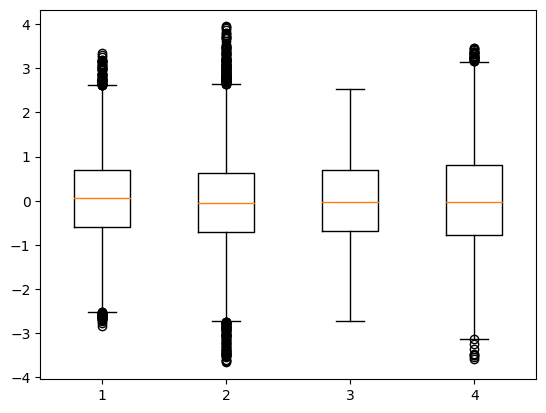

In [16]:
plt.boxplot([clim_RMM['DJF'][:,0],clim_RMM['MAM'][:,0],clim_RMM['JJA'][:,0],clim_RMM['SON'][:,0]])



In [2]:
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMSE = np.zeros((8,5))
BCC = np.zeros((8,5))
err = np.zeros((8,5))
del a 

for i,lead in zip(np.arange(0,8),[1,3,5,10,15,20,25,30]):
    for yn in np.arange(2015,2020):
        # fnp = dirn + 'predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnp = dirn + 'predicted_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnpstd = dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dsstd = pd.read_csv(fnpstd, header=None, names=['std1','std2'])

        a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
        RMM1 = a['RMM'][:,0]
        RMM2 = a['RMM'][:,1]
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
        std1 = dsstd['std1']
        std2 = dsstd['std2']
        std = np.sqrt(std1*std1+std2*std2) / 2.0

        ds = pd.concat((dsp,dst), axis=1)
        ds['IniAmp'] = IniAmp.values 
        ds['std'] = std.values
        # ds = ds.iloc[274:,:]

        ds = ds.loc[ds['IniAmp']>=1]

        r1p = np.asarray(ds['RMMp1'])
        r2p = np.asarray(ds['RMMp2'])
        r1t = np.asarray(ds['RMMt1'])
        r2t = np.asarray(ds['RMMt2'])
        std = np.asarray(ds['std'])
        
        A = np.sum(r1p * r1t + r2p * r2t)
        B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
        C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
        BCC[i,yn-2015] = A / B / C 

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE[i,yn-2015] = np.sqrt(np.mean(d))
        err[i,yn-2015] = np.mean(std)
        del a 


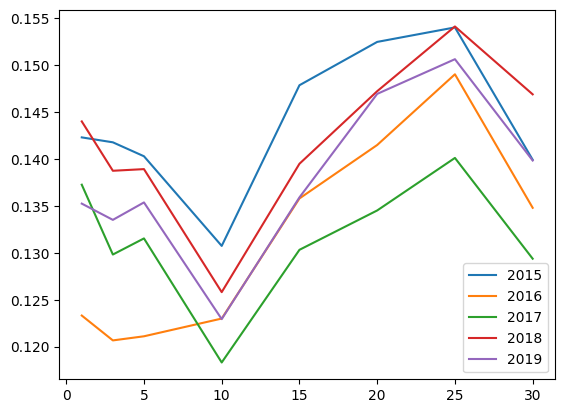

In [13]:
plt.plot([1,3,5,10,15,20,25,30], err, label=['2015','2016','2017','2018','2019'])
plt.legend()

Text(0, 0.5, 'RMSE')

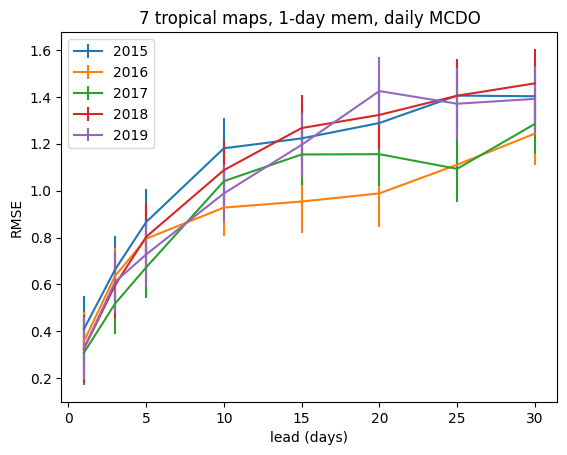

In [5]:
import matplotlib.pyplot as plt 

plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,0], yerr=err[:,0], label='2015')
# plt.plot([1,3,5,10,15,20,25,30], RMSE, 'o-', label=['2015','2016','2017','2018','2019'])
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'BCC')

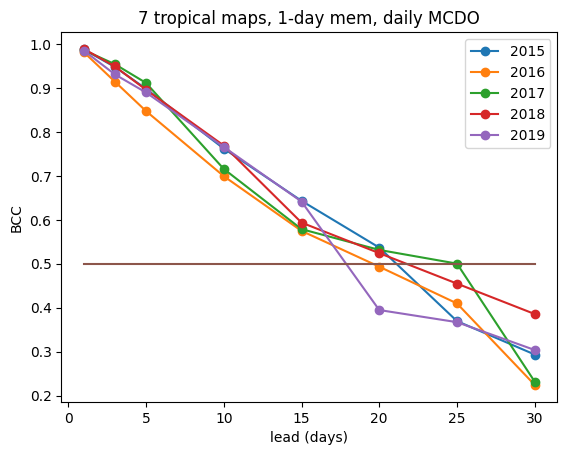

In [6]:
import matplotlib.pyplot as plt 

# plt.errorbar([1,3,5,10,15,20,25,30], BCC[:,3], yerr=err[:,3])
plt.plot([1,3,5,10,15,20,25,30], BCC, 'o-', label=['2015','2016','2017','2018','2019'])
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
plt.plot([1,3,5,10,15,20,25,30], 0.5 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

In [20]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'

BCC = np.zeros(7)
RMSE = np.zeros(7)
err = np.zeros(7)

for i, lead in zip(np.arange(8),[1,5,10,15,20,25,30]):
    dsp0 = []
    dst0 = []
    dspstd0 = []
    for yn in np.arange(2015,2020):
        fnp = dirn + 'predicted_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnpstd = dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dsp0.append(dsp)
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dst0.append(dst)
        dspstd = pd.read_csv(fnpstd, header=None, names=['std1','std2'])
        dspstd0.append(dspstd)

    dsp = pd.concat(dsp0, axis=0, ignore_index=True)
    dst = pd.concat(dst0, axis=0, ignore_index=True)
    dspstd = pd.concat(dspstd0, axis=0, ignore_index=True)

    ds = pd.concat((dsp,dst,dspstd), axis=1)
    ds['IniAmp'] = IniAmp.values 

    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    std1 = np.asarray(ds['std1'])
    std2 = np.asarray(ds['std2'])

    del ds 
    del dsp 
    del dst 

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[i] = A / B / C 
    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE[i] = np.sqrt(np.mean(d))
    err[i] = np.mean(np.sqrt(std1*std1+std2*std2)/2.0)



Text(0, 0.5, 'RMSE')

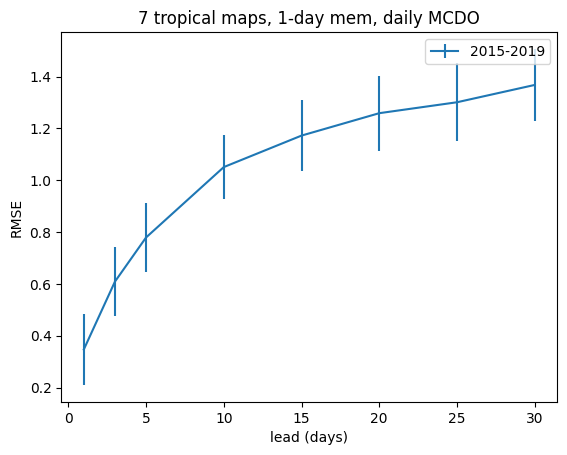

In [23]:
import matplotlib.pyplot as plt 

plt.errorbar([1,3,5,10,15,20,25,30], RMSE, yerr=err, label='2015-2019')
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'BCC')

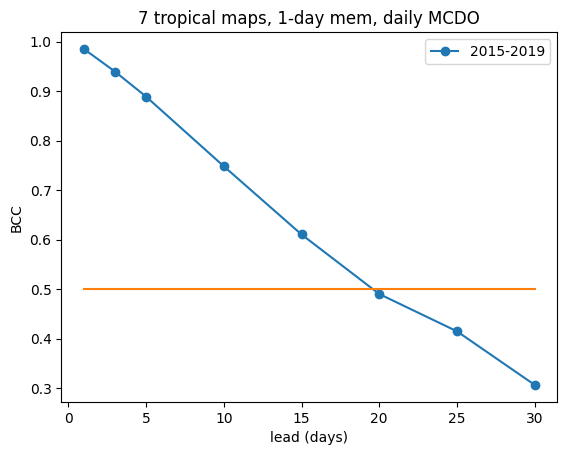

In [22]:
import matplotlib.pyplot as plt 

# plt.errorbar([1,3,5,10,15,20,25,30], BCC[:,3], yerr=err[:,3])
plt.plot([1,3,5,10,15,20,25,30], BCC, 'o-', label='2015-2019')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
plt.plot([1,3,5,10,15,20,25,30], 0.5 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

Text(0, 0.5, 'BCC')

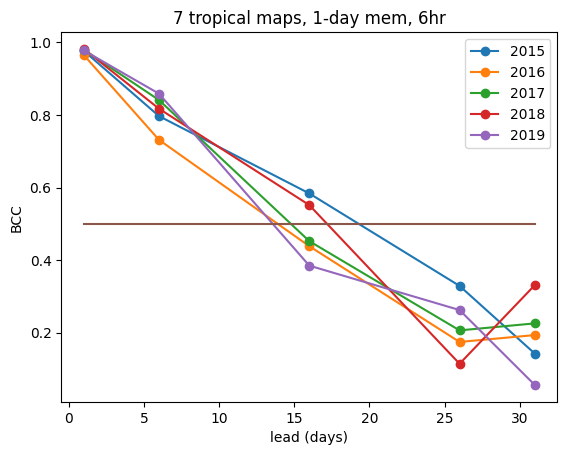

In [12]:
import matplotlib.pyplot as plt 

plt.plot([1,6,16,26,31], BCC, 'o-', label=['2015','2016','2017','2018','2019'])
plt.plot([1,6,16,26,31], 0.5 * np.ones(5))
plt.legend()
plt.title('7 tropical maps, 1-day mem, 6hr')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

Text(0, 0.5, 'BCC')

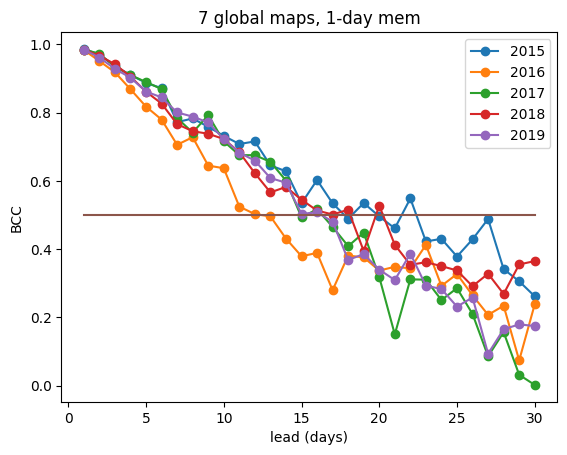

In [47]:
import matplotlib.pyplot as plt 

plt.plot(np.arange(1,31), BCC, 'o-', label=['2015','2016','2017','2018','2019'])
plt.plot(np.arange(1,31), 0.5 * np.ones(30))
plt.legend()
plt.title('7 global maps, 1-day mem')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

Text(0, 0.5, 'BCC')

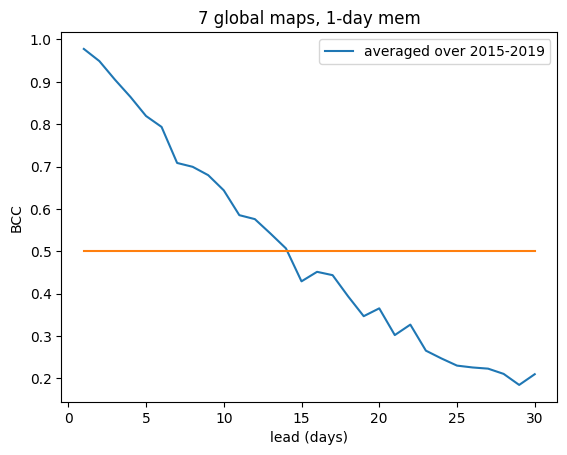

In [7]:
dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered/output/'

BCC = np.zeros(30)

for lead in np.arange(1,31):
    dsp0 = []
    dst0 = []
    for yn in np.arange(2015,2020):
        fnp = dirn + 'predicted_UNET_7maps_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_UNET_7maps_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMM1','RMM2'])
        dsp0.append(dsp)
        dst = pd.read_csv(fnt, header=None, names=['RMM1','RMM2'])
        dst0.append(dst)

    dsp = pd.concat(dsp0, axis=0, ignore_index=True)
    dst = pd.concat(dst0, axis=0, ignore_index=True)

    r1p = np.asarray(dsp['RMM1'])
    r2p = np.asarray(dsp['RMM2'])
    r1t = np.asarray(dst['RMM1'])
    r2t = np.asarray(dst['RMM2'])

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[lead-1] = A / B / C 

plt.plot(np.arange(1,31), BCC, label='averaged over 2015-2019')
plt.plot(np.arange(1,31), 0.5 * np.ones(30))
plt.legend()
plt.title('7 global maps, 1-day mem')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

In [8]:
BCC

array([0.97764833, 0.94888447, 0.90509722, 0.86426292, 0.81929305,
       0.79348245, 0.70840397, 0.69930314, 0.67956514, 0.64377307,
       0.58514906, 0.57578864, 0.54185711, 0.50661787, 0.42889534,
       0.45134186, 0.44346924, 0.39332898, 0.34661264, 0.36511589,
       0.30200094, 0.32669118, 0.26522521, 0.24679897, 0.22991608,
       0.22554002, 0.2227457 , 0.21037413, 0.1843189 , 0.20961831])

In [9]:
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
IniAmp 

<xarray.DataArray 'RMM' (time: 1825)>
array([1.4046578 , 1.2001272 , 1.2132179 , ..., 1.1861416 , 0.95368093,
       0.5954991 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-31

Text(0, 0.5, 'BCC')

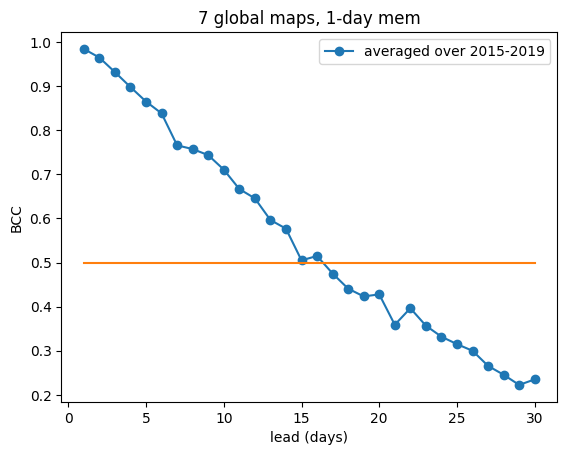

In [45]:
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered/output/'

BCC = np.zeros(30)

for lead in np.arange(1,31):
    dsp0 = []
    dst0 = []
    for yn in np.arange(2015,2020):
        fnp = dirn + 'predicted_UNET_7maps_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_UNET_7maps_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dsp0.append(dsp)
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dst0.append(dst)

    dsp = pd.concat(dsp0, axis=0, ignore_index=True)
    dst = pd.concat(dst0, axis=0, ignore_index=True)

    ds = pd.concat((dsp,dst), axis=1)
    ds['IniAmp'] = IniAmp.values 

    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])

    del ds 
    del dsp 
    del dst 

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[lead-1] = A / B / C 

plt.plot(np.arange(1,31), BCC, 'o-', label='averaged over 2015-2019')
plt.plot(np.arange(1,31), 0.5 * np.ones(30))
plt.legend()
plt.title('7 global maps, 1-day mem')
plt.xlabel('lead (days)')
plt.ylabel('BCC')


In [24]:
ds 

,RMM1,RMM2,RMM1,RMM2
0,0.981364,-0.535016,1.147635,-0.351055
1,1.243399,-0.296870,1.212031,0.053654
2,1.416136,0.115459,1.436842,0.302816
3,1.616447,0.385177,1.819747,0.564866
4,1.886212,0.576957,1.997545,0.550993
...,...,...,...,...
1820,-0.040157,0.793768,-0.132474,1.103801
1821,-0.439627,0.807106,-0.469978,1.089061
1822,-0.858364,0.590929,-0.564833,0.768421
1823,-0.738712,0.280681,-0.444110,0.396718


In [27]:
ds = ds.loc[ds['IniAmp']>=1]
ds 

,RMM1,RMM2,RMM1,RMM2,IniAmp
0,0.981364,-0.535016,1.147635,-0.351055,1.404658
1,1.243399,-0.296870,1.212031,0.053654,1.200127
2,1.416136,0.115459,1.436842,0.302816,1.213218
3,1.616447,0.385177,1.819747,0.564866,1.468404
4,1.886212,0.576957,1.997545,0.550993,1.905401
...,...,...,...,...,...
1818,0.661145,0.834693,0.647595,1.174329,1.230509
1819,0.424186,0.783205,0.336641,1.216464,1.341055
1820,-0.040157,0.793768,-0.132474,1.103801,1.262185
1821,-0.439627,0.807106,-0.469978,1.089061,1.111723


In [26]:
ds 

,RMM1,RMM2,RMM1,RMM2,IniAmp
0,0.981364,-0.535016,1.147635,-0.351055,1.404658
1,1.243399,-0.296870,1.212031,0.053654,1.200127
2,1.416136,0.115459,1.436842,0.302816,1.213218
3,1.616447,0.385177,1.819747,0.564866,1.468404
4,1.886212,0.576957,1.997545,0.550993,1.905401
...,...,...,...,...,...
1820,-0.040157,0.793768,-0.132474,1.103801,1.262185
1821,-0.439627,0.807106,-0.469978,1.089061,1.111723
1822,-0.858364,0.590929,-0.564833,0.768421,1.186142
1823,-0.738712,0.280681,-0.444110,0.396718,0.953681


Text(0, 0.5, 'BCC')

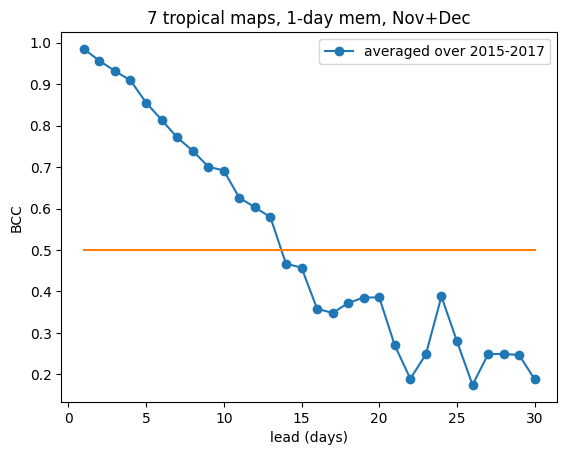

In [62]:
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2017-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered_trop/output/'

BCC = np.zeros(30)

for lead in np.arange(1,31):
    dsp0 = []
    dst0 = []
    for yn in np.arange(2015,2018):
        fnp = dirn + 'predicted_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dsp0.append(dsp)
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dst0.append(dst)

    dsp = pd.concat(dsp0, axis=0, ignore_index=True)
    dst = pd.concat(dst0, axis=0, ignore_index=True)

    ds = pd.concat((dsp,dst), axis=1)
    ds['IniAmp'] = IniAmp.values 
    ds = ds.iloc[304:,:]

    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])

    del ds 
    del dsp 
    del dst 

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[lead-1] = A / B / C 

plt.plot(np.arange(1,31), BCC, 'o-', label='averaged over 2015-2017')
plt.plot(np.arange(1,31), 0.5 * np.ones(30))
plt.legend()
plt.title('7 tropical maps, 1-day mem, Nov+Dec')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

array([[1.14510333e-310, 1.14510333e-310, 2.21933340e-316,
        2.21933340e-316, 0.00000000e+000],
       [0.00000000e+000,             nan, 0.00000000e+000,
        4.94065646e-324, 0.00000000e+000],
       [4.44659081e-323, 1.14494372e-310, 9.76403161e-317,
                    nan, 0.00000000e+000],
       [            nan, 0.00000000e+000, 7.68638430e+275,
        3.55727265e-322, 5.43472210e-323],
       [1.14494372e-310, 9.76403952e-317, 1.48219694e-323,
        1.38338381e-322,             nan],
       [0.00000000e+000, 5.38284496e+228, 7.11454530e-322,
        5.43472210e-323, 1.14494372e-310],
       [9.76404347e-317, 0.00000000e+000, 1.38338381e-322,
                    nan, 4.94065646e-323],
       [1.14481673e-310, 1.06718180e-321, 3.95252517e-323,
        1.14494372e-310, 9.76565017e-317],
       [5.99998459e-317, 1.28457068e-322,             nan,
        0.00000000e+000, 1.14481673e-310],
       [1.42290906e-321, 5.43472210e-323, 1.14494372e-310,
        9.76298024e-317

In [ ]:
dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered_trop/output/'
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

BCC = []
yn = 2015
iniRMM = xr.concat((a,b), dim='time')

del a 

for lead in np.arange(1,31):

    fnp = dirn + 'predicted_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
    fnt = dirn + 'truth_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

    dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
    dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])

    a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
    RMM1 = a['RMM'][:,0]
    RMM2 = a['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

    ds = pd.concat((dsp,dst), axis=1)
    ds['IniAmp'] = IniAmp.values 

    ds = ds.loc[ds['IniAmp']>=1]

    pc1p = np.asarray(ds['RMMp1'])
    pc2p = np.asarray(ds['RMMp2'])
    pc1t = np.asarray(ds['RMMt1'])
    pc2t = np.asarray(ds['RMMt2'])

    d = (pc1t-pc1p)*(pc1t-pc1p)+(pc2t-pc2p)*(pc2t-pc2p)
    tmp = np.sqrt(d)
    # A = r1p * r1t + r2p * r2t
    # B = np.sqrt(r1p * r1p + r2p * r2p)
    # C = np.sqrt(r1t * r1t + r2t * r2t)
    # tmp = A / B / C 
    # BCC.append(tmp)

    plt.boxplot(d)
    # plt.scatter(lead*np.ones(tmp.shape), tmp)  # , label=['2015','2016','2017','2018','2019'])
    del tmp 
    # plt.plot(np.arange(1,31), 0.5 * np.ones(30))
    # plt.legend()
    # plt.title('7 tropical maps, 1-day mem')
    # plt.xlabel('lead (days)')
    # plt.ylabel('BCC')

In [35]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered_trop/output/'
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

BCC = []
RMSE = []

iniRMM = xr.concat((a,b), dim='time')

del a 

for yn in np.arange(2015,2016):

    for lead in np.arange(1,31):

        fnp = dirn + 'predicted_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])

        a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
        RMM1 = a['RMM'][:,0]
        RMM2 = a['RMM'][:,1]
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

        ds = pd.concat((dsp,dst), axis=1)
        ds['IniAmp'] = IniAmp.values 
        ds['time'] = a['time']

        ds = ds.iloc[0:,:]

        ds = ds.loc[ds['IniAmp']>=1]

        pc1p = np.asarray(ds['RMMp1'])
        pc2p = np.asarray(ds['RMMp2'])
        pc1t = np.asarray(ds['RMMt1'])
        pc2t = np.asarray(ds['RMMt2'])

        d = (pc1t-pc1p)*(pc1t-pc1p)+(pc2t-pc2p)*(pc2t-pc2p)
        tmp = np.sqrt(d)
        RMSE.append(tmp)

        del tmp 
        
        r1p = np.asarray(ds['RMMp1'])
        r2p = np.asarray(ds['RMMp2'])
        r1t = np.asarray(ds['RMMt1'])
        r2t = np.asarray(ds['RMMt2'])

        A = r1p * r1t + r2p * r2t
        B = np.sqrt(r1p * r1p + r2p * r2p)
        C = np.sqrt(r1t * r1t + r2t * r2t)
        tmp = A / B / C 
        BCC.append(tmp)

        # plt.scatter(lead*np.ones(tmp.shape), tmp)  # , label=['2015','2016','2017','2018','2019'])
        del tmp 
        # plt.plot(np.arange(1,31), 0.5 * np.ones(30))
        # plt.legend()
        # plt.title('7 tropical maps, 1-day mem')
        # plt.xlabel('lead (days)')
        # plt.ylabel('BCC')



Text(0.5, 1.0, '2015')

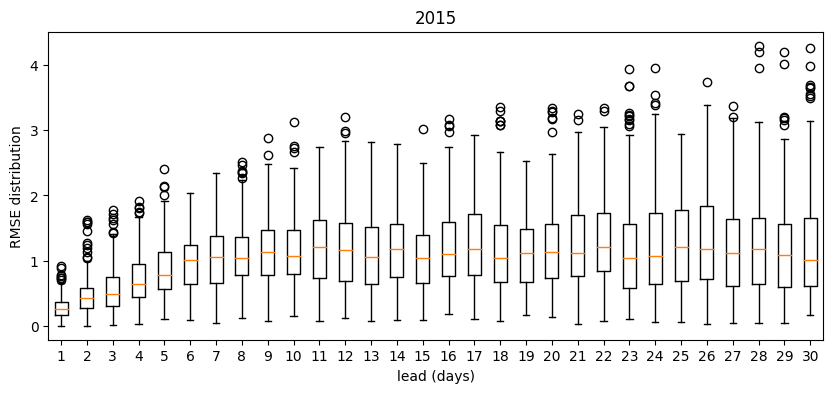

In [41]:
fig = plt.figure(figsize=(10,4))
plt.boxplot(RMSE)
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.title(str(yn))


Text(0.5, 1.0, '2015')

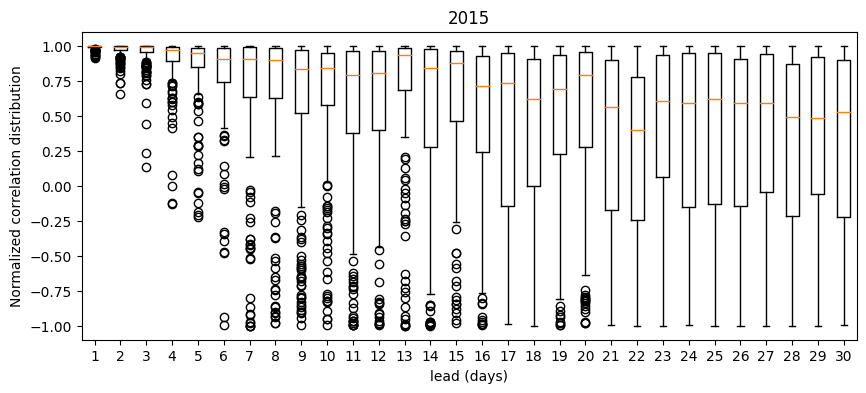

In [40]:
fig = plt.figure(figsize=(10,4))
plt.boxplot(BCC)
plt.xlabel('lead (days)')
plt.ylabel('Normalized correlation distribution')
plt.title(str(yn))

In [18]:
a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
a['time']

<xarray.DataArray 'time' (time: 365)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31

In [19]:
ds 

,RMMp1,RMMp2,RMMt1,RMMt2,IniAmp,time
0,1.008925,-0.284374,1.147635,-0.351055,1.404658,2015-01-01
1,0.981014,-0.022622,1.212031,0.053654,1.200127,2015-01-02
2,1.149683,0.384596,1.436842,0.302816,1.213218,2015-01-03
3,1.498712,0.548154,1.819747,0.564866,1.468404,2015-01-04
4,1.741250,0.626155,1.997545,0.550993,1.905401,2015-01-05
...,...,...,...,...,...,...
360,1.058694,1.613903,1.064587,1.948920,2.040500,2015-12-27
361,0.783149,1.915899,0.816755,2.020008,2.220729,2015-12-28
362,0.486708,2.005704,0.544168,2.071584,2.178880,2015-12-29
363,0.191700,1.980605,0.327835,1.936739,2.141863,2015-12-30


In [24]:
ds['time'] > np.datetime64(str(yn)+'-11-31')

ValueError: Day out of range in datetime string "2015-11-31"

In [22]:
ds['time']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
360   2015-12-27
361   2015-12-28
362   2015-12-29
363   2015-12-30
364   2015-12-31
Name: time, Length: 365, dtype: datetime64[ns]

In [23]:
yn 

2015

In [31]:
ds.iloc[304:,:]

,RMMp1,RMMp2,RMMt1,RMMt2,IniAmp,time
304,-1.062838,-2.011106,-1.098881,-2.035240,2.497833,2015-11-01
305,-0.822965,-2.003790,-0.852159,-2.056617,2.312951,2015-11-02
306,-0.692646,-1.972008,-0.719629,-2.113865,2.226173,2015-11-03
307,-0.581151,-1.866284,-0.390892,-2.037210,2.233000,2015-11-04
308,-0.176067,-1.823130,-0.140308,-2.106477,2.074372,2015-11-05
...,...,...,...,...,...,...
360,1.058694,1.613903,1.064587,1.948920,2.040500,2015-12-27
361,0.783149,1.915899,0.816755,2.020008,2.220729,2015-12-28
362,0.486708,2.005704,0.544168,2.071584,2.178880,2015-12-29
363,0.191700,1.980605,0.327835,1.936739,2.141863,2015-12-30


In [51]:
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2016-02-20','2016-03-01'))

In [52]:
a

<xarray.Dataset>
Dimensions:  (time: 11, mode: 2)
Coordinates:
  * time     (time) datetime64[ns] 2016-02-20 2016-02-21 ... 2016-03-01
  * mode     (mode) int64 0 1
Data variables:
    RMM      (time, mode) float32 ...